In [1]:
import tensorflow as tf
import torch
import numpy as np
import os
import gc
import random
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [146]:
# create dataset and split into training, validation, and test sets

# img_dir is the directory where the images are located
# please modify as needed to match the folder structure
img_dir = './training_data/color/'
mask_dir = './training_data/mask/'

data_filenames = os.listdir(img_dir)
mask_filenames = os.listdir(mask_dir)
img_paths = [img_dir + p for p in data_filenames]
mask_paths = [mask_dir + p for p in mask_filenames]
take_idx = np.arange(10000)
np.random.shuffle(take_idx)
img_paths = np.take(img_paths, take_idx)
mask_paths = np.take(mask_paths, take_idx)
img_train, mask_train = img_paths[:8000], mask_paths[:8000]
img_val, mask_val = img_paths[8000:9000], mask_paths[8000:9000]
img_test, mask_test = img_paths[9000:], mask_paths[9000:]

class FingerDataset(Dataset):
    def __init__(self, data_paths, mask_paths, img_transform=None, mask_transform=None):
        data_filenames = os.listdir(img_dir)
        self.data_paths = data_paths
        self.mask_paths = mask_paths
        self.img_transform = img_transform
        # necessary if using transformations like rotation, flipping or cropping
        # in which case need to apply to both image and mask
        self.mask_transform = mask_transform
    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        img_path = self.data_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

In [147]:
img_train

array(['./training_data/color/color_img0007610.jpg',
       './training_data/color/color_img0002327.jpg',
       './training_data/color/color_img0009712.jpg', ...,
       './training_data/color/color_img0005586.jpg',
       './training_data/color/color_img0008423.jpg',
       './training_data/color/color_img0002213.jpg'], dtype='<U42')

In [541]:
# Resize and CenterCrop accepts either PIL Image or Tensor. 
# Previous attempts to normalize tensor from torchvision.io.read_image yielded incorrect outputs
# Use Pillow to read PIL image then convert to tensor worked well
totensor = transforms.ToTensor()
# # smaller edge of the image will be matched to 224
# resize = transforms.Resize(224)
# # center square crop of (250, 250)
# crop = transforms.CenterCrop(250)
# To use pretrained models, input must be normalized as follows (pytorch models documentation): 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Data augmentation transforms:
# applied randomly with probability p instead of explicitly appending transformed data to original dataset
# which means the model will eventually be trained on the original + augmented dataset over many epochs
grayscale = transforms.RandomGrayscale(p=0.1)
# randomly changes the brightness, saturation, and other properties of an image
jitter = transforms.ColorJitter(brightness=.4, hue=.2)

# threshold the images with opencv to reduce noise and improve generalization
# reference: https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
def threshold(img):
    output = np.zeros(img.shape)
    for i in range(3):
        output[:,:,i] = cv.threshold(cv.GaussianBlur(img[:,:,i],(5,5),0),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
    return output

# used to break image into smaller tiles
# reference: https://discuss.pytorch.org/t/split-an-image-into-four-equal-coordinates/84895
def tile(img, vsize=40, hsize=40):
    x = img.clone()
    x = x.unfold(1, vsize, vsize)
    x = x.unfold(2, hsize, hsize)
    x = x.reshape(3, -1, vsize, hsize)
    return x

# compose the pre-processing and augmentation transforms
composed_aug_transforms = transforms.Compose((grayscale, jitter, np.array, threshold, totensor, normalize, tile))
# test data typically should not be augmented
no_aug_transforms = transforms.Compose((threshold, totensor, normalize, tile))
# mask also need to be converted to tensor
mask_transform = transforms.Compose((totensor, tile))

data_train = FingerDataset(img_train, mask_train, img_transform=composed_aug_transforms, mask_transform=mask_transform)
data_val = FingerDataset(img_val, mask_val, img_transform=no_aug_transforms, mask_transform=mask_transform)
data_test = FingerDataset(img_test, mask_test, img_transform=no_aug_transforms, mask_transform=mask_transform)

# initialize dataloaders for the dataset
loader_train = DataLoader(data_train, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
loader_val = DataLoader(data_val, batch_size=16, shuffle=True, num_workers=0, drop_last=True)
loader_test = DataLoader(data_test, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

torch.Size([16, 3, 192, 40, 40])


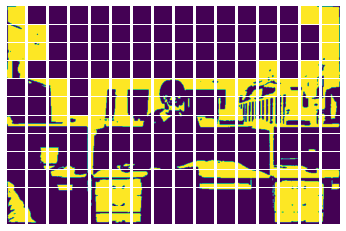

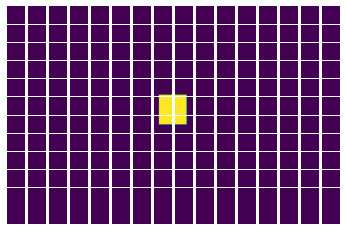

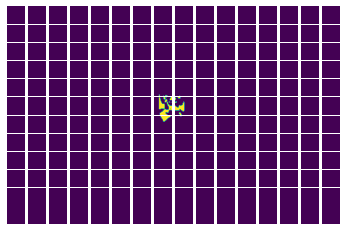

In [542]:
# plot single-channel tiles together
def plot_tiles(img, num_tiles_v, num_tiles_h):
    
    v, h = num_tiles_v, num_tiles_h 
    fig, axs = plt.subplots(v, h) 
    for i in range(v):
        for j in range(h):
            # absolute is used because plt.imshow has odd habit of showing -0.0 as bright blocks
            axs[i,j].imshow(np.absolute(img[i*h+j]))
            axs[i,j].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
   
x, y = next(iter(loader_train))
print(x.shape)
tile_height, tile_width = 40, 40
v, h = int(480/tile_height), int(640/tile_width)
plot_tiles(x[0][0], v, h)
plot_tiles(y[0][0], v, h)
plot_tiles(x[0][0]*y[0][0], v, h)

In [543]:
resnet18 = models.resnet18(pretrained=True)
# replace last layer
resnet18.fc = nn.Linear(512, 400)
for param in resnet18.parameters():
    param.require_grad = False
resnet18.fc.requires_grad_(True)

Linear(in_features=512, out_features=400, bias=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  